## Introduction

This blog post will explore the data behind loan granting from various perspectives. The data will first be shown "as is" through visualizations and data tables. Then, a model will be trained on the data through the creation of a scoring function and threshold. Finally, more in-depth quantiative analysis will be done on the profits, costs, and biases that are created from the model. Through this study, a profitable model for the bank was found, but this came at the cost of differing acceptance rates across groups.

## Part A: Grab the Data

First, the data is converted to a dataframe through pandas and checked using the head() function

In [1]:
import pandas as pd
from itertools import combinations
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import cross_val_score
import warnings

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [2]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## Part B: Explore the Data

I first investigated the relationship between personal income, financial history, and loan amounts. I did this by creating a table that groups by income intervals of 10000 and checking credit history and the size of the loan. It shows that loan amounts granted increase as personal income increases, while one's credit history tends to be higher as income increases, but this isn't as drastic of an upward trend.

In [3]:
df_train["income_group"] = df_train["person_income"] // 10000

df_train.groupby(["income_group"])[["loan_amnt", "cb_person_cred_hist_length"]].aggregate("mean")[:20]

,loan_amnt,cb_person_cred_hist_length
income_group,,
0,2093.333333,5.566667
1,3837.235367,5.282690
2,5731.833494,5.532243
3,7298.140863,5.541371
4,8220.600000,5.630667
5,9237.460703,5.595313
6,10044.702093,5.689211
7,11152.793002,5.836003
8,11724.719801,5.957659


### Visualizations

I then mapped aspects about the loan with respect to whether or not the grantee has previously defaulted on their loan. I mapped this as a seaborn scatterplot using loan interest rate and percent income. This revealed that those with a prior default on history are almost never granted an interest rate lower than 12%. However, previous defaults don't seem to affect the loan as percentage of income.

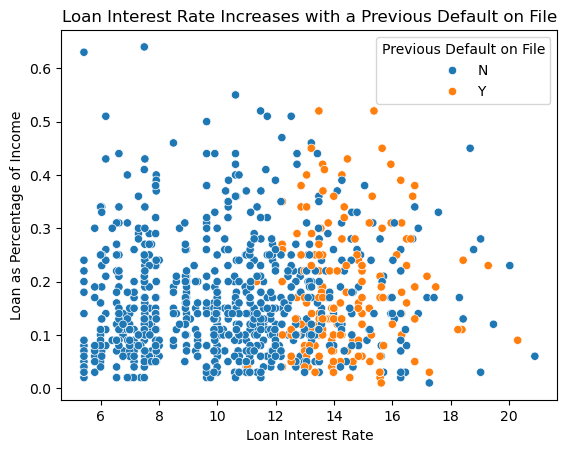

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

g1 = sns.scatterplot(data=df_train[:1000], x="loan_int_rate", y="loan_percent_income", hue="cb_person_default_on_file")
g1.set_title("Loan Interest Rate Increases with a Previous Default on File")
g1.set_xlabel("Loan Interest Rate")
g1.set_ylabel("Loan as Percentage of Income")
plt.legend(title="Previous Default on File")
                     

Finally, I looked into the impact one's age and home ownership status has on their loan status (whether or not they default) using a seaborn lineplot. It shows that defaulting on loans for those who rent stay fairly stable (and high) from around 20-70 years old. The default rate is much lower for those with mortgages than those who pay rent, and it tends to go down with age. While the rate of default for mortgages jumps up at 60, there are only 3 datapoints for this, so it may be an outlier. Home ownership default rates are the lowest, also trending downward over time (reaching a 0% default rate at 60). Finally, the "other" category fluctuates wildly, increasing drastically between those in their 20s and 30s, then decreasing even more between those in their 30s and 40s. No data exists on "other" home ownership exists in this data for those above their 40s.

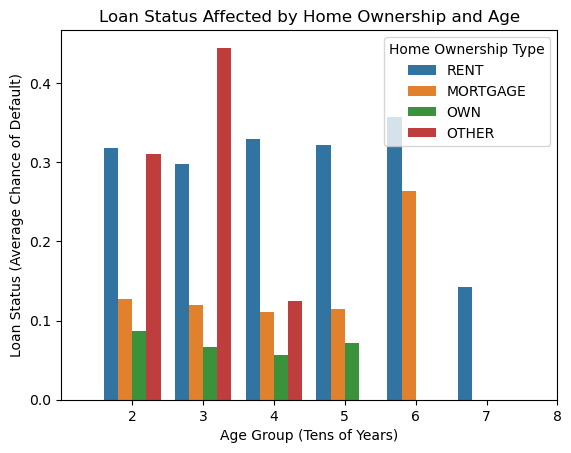

In [6]:
df_train["age_group"] = df_train["person_age"] // 10

# axis limiting information from: https://stackoverflow.com/questions/54822884/how-to-change-the-x-axis-range-in-seaborn
fig, ax = plt.subplots()

g2 = sns.barplot(data=df_train, x="age_group", y="loan_status", hue="person_home_ownership", errorbar=None, ax=ax)

g2.set_title("Loan Status Affected by Home Ownership and Age")
g2.set_xlabel("Age Group (Tens of Years)")
g2.set_ylabel("Loan Status (Average Chance of Default)")
plt.legend(title="Home Ownership Type")

ax.set_xlim(-1, 6)
plt.show()

## Part C: Build a Model

I then wanted to create a model to predict whether or not an applicant would default on their loan. To start, I processed the data to drop loan_grade (which was already a prediction) and loan_status (what the model is predicting). Further, I use pd.get_dummies to convert qualitative columns like "person_home_ownership" to become true/false columns for each possible answer of the column (e.g. person_home_ownership_RENT).

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["loan_status"])

def prepare_data(df):
  df = df.drop(["loan_grade"], axis = 1)
  df = df.dropna()
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)

In [9]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,income_group,age_group,person_home_ownership_MORTGAGE,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,9,2,False,...,False,True,False,True,False,False,False,False,False,True
2,22,36996,5.0,10000,7.51,0.27,4,3,2,False,...,False,True,False,True,False,False,False,False,True,False
3,24,26000,2.0,1325,12.87,0.05,4,2,2,False,...,False,True,False,False,False,True,False,False,True,False
4,29,53004,2.0,15000,9.63,0.28,10,5,2,True,...,False,False,False,False,True,False,False,False,True,False
6,21,21700,2.0,5500,14.91,0.25,2,2,2,False,...,False,True,False,False,True,False,False,False,True,False


I then used a logistic regression (LR) model from scikit-learn to figure out the most important variables for the model to consider and the weights of their importance. I did this by procedurally iterating through one qualitative column and different pairs of quantitative column and scoring the LR model through cross-validation. The best scoring columns were saved and output for future use. 

In [10]:
warnings.filterwarnings("ignore") # just ignores the convergence warning in this case

results_LR = []

all_qual_cols = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]
all_quant_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt",
                  "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 

    LR = LogisticRegression()

    cv_scores_LR = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    new_score_LR = cv_scores_LR.mean()
    results_LR.append((new_score_LR, cols))

results_LR.sort(reverse=True, key=lambda x : x[0])
print(results_LR)

[(0.8486483607400082, ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_percent_income', 'cb_person_cred_hist_length']), (0.8485174611967847, ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_emp_length', 'loan_percent_income']), (0.8485174326119376, ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_age', 'loan_percent_income']), (0.8455491439743476, ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_int_rate', 'loan_percent_income']), (0.8317106287322877, ['loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_int_rate', 'loan_percent_income']), (0.8234163

With the columns defined, we can get the weights of each column using LogisticRegression.coef_.

In [11]:
cols = ['person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN',
         'person_home_ownership_RENT', 'loan_percent_income', 'cb_person_cred_hist_length']

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)

LR.coef_

array([[-1.64154192e-01,  4.97682620e-01, -1.20631381e+00,
         8.71319225e-01,  8.28169156e+00, -4.40583292e-03]])

A simple linear score function is defined here as the inner product between the values of the relevant columns (X) and the values of w (our weights, defined above). X_train is then given profit, cost, and score columns based on the profit and cost functions provided.

In [12]:
def linear_score(w, X):
    return X@w

In [13]:
X_train["profit"] = X_train["loan_amnt"]*(1 + 0.25*0.01*X_train["loan_int_rate"])**10 - X_train["loan_amnt"]

X_train["cost"] = X_train["loan_amnt"]*(1 + 0.25*0.01*X_train["loan_int_rate"])**3 - 1.7*X_train["loan_amnt"]

X_train["score"] = linear_score(np.transpose(LR.coef_), X_train[cols])

## Part D: Find a Threshold

The model is then optimized for maximum profit for the bank. This algorithm checks for each threshold value between the minimum and maximum scores in the training data. The profit for each threshold is calculated as 0 if the model predicts a default (the loan being denied), the value of the profit column if the value of loan_status is 0 (no default), and the value of the cost column is the value of loan_status is 1.

In [14]:
X_train["score"].min(), X_train["score"].max()

(-1.1719610565334115, 7.23941006007273)

In [15]:
max_profit = float('-inf')
thresh = -1.17

for t in np.arange(-1.17, 7.23, 0.01, dtype=float):
    temp_prof = ((X_train["score"] < t) * ((y_train == 0) * X_train["profit"] + (y_train == 1) * X_train["cost"])).mean()
    if (temp_prof > max_profit):
        max_profit = temp_prof
        thresh = t

max_profit, thresh


(1448.4426481197982, 3.350000000000004)

## Part E: Evaluate Your Model from the Bank's Perspective

With a max profit of $1448 and a threshold of 3.35, I apply the scoring function and threshold to the testing data. This threshold and set of weights achieved a testing profit of $1392.

In [16]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

X_test, y_test = prepare_data(df_test)

In [17]:
thresh = 3.35

X_test["profit"] = X_test["loan_amnt"]*(1 + 0.25*0.01*X_test["loan_int_rate"])**10 - X_test["loan_amnt"]
X_test["cost"] = X_test["loan_amnt"]*(1 + 0.25*0.01*X_test["loan_int_rate"])**3 - 1.7*X_test["loan_amnt"]

X_test["score"] = linear_score(np.transpose(LR.coef_), X_test[cols])

# if the score is under the threshold, the person is predicted not to default, so the loan is given
((X_test["score"] < thresh) * ((y_test == 0) * X_test["profit"] + (y_test == 1) * X_test["cost"])).mean()

1392.1021914117252

I also added a "loan_granted" column, which just negates the prediction of the model (i.e. if no default is predicted, the loan is granted). This makes some of the logic easier by preventing negations of the prediction column later on.

In [18]:
# prediction is whether or not a default will occur
X_test["pred"] = X_test["score"] > thresh
X_test["loan_granted"] = ~X_test["pred"]
X_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y,profit,cost,score,pred,loan_granted
0,21,42000,5.0,1000,15.58,0.02,4,False,False,False,...,False,False,True,True,False,465.367227,-578.539601,1.01933,False,True
1,32,51000,2.0,15000,11.36,0.29,9,True,False,False,...,False,False,False,True,False,4847.780062,-9185.361205,2.197884,False,True
2,35,54084,2.0,3000,12.61,0.06,6,False,False,False,...,False,False,False,True,False,1091.841800,-1807.236578,1.341786,False,True
3,28,66300,11.0,12000,14.11,0.15,6,True,False,False,...,True,False,False,True,False,4972.214553,-7084.777554,1.051665,False,True
4,22,70550,0.0,7000,15.88,0.08,3,False,False,False,...,True,False,False,True,False,3331.859215,-4032.764115,1.520637,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6511,29,78000,2.0,18000,6.62,0.23,5,True,False,False,...,False,True,False,True,False,3210.941787,-11691.427669,1.718606,False,True
6513,27,44640,0.0,12800,11.83,0.29,9,False,False,False,...,True,False,False,True,False,4331.281644,-7790.401145,3.233357,False,True
6514,24,48000,5.0,10400,7.37,0.22,3,False,False,True,...,False,False,True,True,False,2083.140437,-6694.483153,0.602441,False,True
6515,26,65000,6.0,6000,9.07,0.09,3,True,False,False,...,False,False,False,True,False,1508.058449,-3782.525248,0.567981,False,True


## Part F: Evaluate Your Model from the Borrower's Perspective

With a complete model, it's important to do analysis on its impact. First, we can see through the creation of an age group column that acceptance rates tend to rise from ages 20 to 44. After this, we see a dip at 45-54 year olds before the rate rises again. Another large outlier is those in group 13 (the 65-69 year old age range), with an acceptance rate of 60%.

In [19]:
# F1
X_test["age_group"] = X_test["person_age"] // 5
X_test.groupby("age_group")["loan_granted"].mean()

age_group
4     0.909465
5     0.916070
6     0.926056
7     0.940758
8     0.942408
9     0.913043
10    0.906250
11    0.900000
12    1.000000
13    0.600000
14    1.000000
Name: loan_granted, dtype: float64

One reason for these large flucuations and 100% acceptance rates, however, could be the low count of applicants in the higher age groups. Although group 13 has the lowest acceptance rate, they also have the lowest sample size with just 5 people. This rise is still notable, especially in groups with larger sample sizes like those in the 20-24 range compared to those in the 40-44 range.

In [20]:
X_test.groupby("age_group")["age_group"].count()

age_group
4     2187
5     1954
6      852
7      422
8      191
9       69
10      32
11      10
12       7
13       5
14       2
Name: age_group, dtype: int64

The next test compares the model's acceptance of those based on loan intent, comparing to its average acceptance rate. Here, we can see that loans for debt consolidaiton, medical expenses, and personal expenses are denied more often than average (where education, home improvement, and venture expenses are approved more often). Here, it is also notable that the model approves loans (i.e. sees no default) much more often than the data dictates that no default will occur.

In [21]:
# F2
intent_cols = [col for col in X_train.columns if "loan_intent" in col ]

model_average = X_test["loan_granted"].mean()
print(f'Model average acceptance: {round(model_average, 6)}\n')

sum = 0
for intent in intent_cols:
    intent_count = X_test[intent].sum()
    model_score = (X_test[intent] & X_test["loan_granted"]).sum()/intent_count
    result = (X_test[intent] & ~y_test).sum()/intent_count

    sum += intent_count
    print(f'{intent[12:]}:')
    print(f'Model grant amount: {round(model_score, 6)}')
    print(f'Actual grant amount: {round(result, 6)}')
    print(f'Model\'s group grant to averge grant ratio: {round(model_score/model_average, 6)}')
    print("")

Model average acceptance: 0.917466

DEBTCONSOLIDATION:
Model grant amount: 0.904867
Actual grant amount: 0.712389
Model's group grant to averge grant ratio: 0.986267

EDUCATION:
Model grant amount: 0.922619
Actual grant amount: 0.832483
Model's group grant to averge grant ratio: 1.005616

HOMEIMPROVEMENT:
Model grant amount: 0.962662
Actual grant amount: 0.75
Model's group grant to averge grant ratio: 1.049262

MEDICAL:
Model grant amount: 0.898416
Actual grant amount: 0.71575
Model's group grant to averge grant ratio: 0.979235

PERSONAL:
Model grant amount: 0.912826
Actual grant amount: 0.779559
Model's group grant to averge grant ratio: 0.994942

VENTURE:
Model grant amount: 0.920124
Actual grant amount: 0.853734
Model's group grant to averge grant ratio: 1.002897



Finally, I checked how the model grants loans to those of different income groups. I did this by (again) dividing the incomes into groups of 10000. When sorting by these groups, it becomes clear that the likelihood of being granted a loan by this model rises drastically as one's income does. Above an income of 110000, this likelihood is 100% (the amount of income groups included is truncated for readability).

In [22]:
# F3
X_test["income_group"] = X_test["person_income"] // 10000
X_test.groupby("income_group")["loan_granted"].mean()[:20]


income_group
0     0.636364
1     0.775194
2     0.805195
3     0.827586
4     0.890346
5     0.939153
6     0.959762
7     0.962891
8     0.976401
9     0.992883
10    0.994737
11    1.000000
12    1.000000
13    1.000000
14    1.000000
15    1.000000
16    1.000000
17    1.000000
18    1.000000
19    1.000000
Name: loan_granted, dtype: float64

## Medical Credit

I would say that it is not fair for those seeking loans for medical expenses to obtain access to credit. Here, I'm defining fairness in a line with a middle view of equality of opportunity; I tend to view these problems from the broad sense, but since we're the taking the view of the decision maker, a broad approach is less applicabale. Specifically, we should act "to avoid perpetuating injustice" (from "Relative Notions of Fairness" in Fairness and Machine Learning).

The middle view here would counteract the unfairness of the medical (particularly healthcare/insurance) system, and the ability of many to access it. The decision maker (the bank) should then act in spite of the situation that left the applicants medically vulnerable and in support of their health and safety.

## Conclusion

Through the creation of this model, I found that the creation of a model that maximizes profit will often deprioritize the health and safety of those affected by it. This was seen in the investigation of different groups the model decides on. Those with medical expenses and less income, for instance, are disproportionately denied by this model. Maximizing for profit, then, shouldn't be seen as the total goal for decision makers. Through this investigation, I also learned that those with previous credit issues are saddled with higher interest rates, increasing the risk of default occuring again. Beyond domain specific findings, I gained practice in thresholding, weighting, and building decision-making models.  